## Develop Your Pricer

In this notebook we would like to give you some tips how you can develop and test your model. Let's assume you have created some model, how do you know it gives the right price? 

As we are calculating prices for European options under the Black Scholes assumptions we have a closed form solution we can compare to. You might ask yourself why then bother to price the option using numerical techniques such as binomial trees? Because in many cases we do not have a closed form solution but we can slightly adapt our binomial tree to calculate these cases. So testing our model against the analytical Black Scholes solution gives us confidence that we do not have a bug in our implementation.

We are giving you the analytical Black Scholes model in the ```bs.py``` file.

In [3]:
import bs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Where Do I Start?

You can either program a Binomial or Trinomial Tree. The Binomial is probably simpler to get running. Remember the steps that you need to take when pricing in a tree? Here they are:

1. Construct the final spot prices: either do this by bootstrapping from the initial spot price step by step or you can use our previous results to construct all final spot nodes. *Note that if your tree has N steps, in a binomial tree you will have N+1 final nodes*
2. Now that you have the final spot values at the time of maturity, you can apply the payoff for the call option. Now you have the option prices at expiry.
3. Go back through the tree step by step, combining the prices using the risk neutral probability. At the same time you should *not forget discounting*.

Here are the formulae you need to construct a $N$-step tree consistent with the input parameters:

<table width=400>
  <th colspan=3> Binomial Tree Parameters </th>
  <tr>
    <td>$$\Delta t$$</td>
    <td>Time Step</td>
    <td> $$ \frac{\tau}{N} $$ </td>
  </tr>
  <tr>
    <td>$$u$$</td>
    <td>Up Move</td>
    <td> $$ e^{\sigma\sqrt{\Delta t}} $$ </td>
  </tr>
  <tr>
    <td>$$d$$</td>
    <td>Down Move</td>
    <td> $$ \frac{1}{u} $$ </td>
  </tr>
  <tr>
    <td>$$p$$</td>
    <td>Probability of Up Move</td>
    <td> $$ \frac{ e^{+r\Delta t} - d}{u-d} $$ </td>
  </tr>
    <tr>
    <td>$$\Phi(\Delta t)$$</td>
    <td>Single Step Discount Factor</td>
    <td> $$ e^{-r\Delta t} $$ </td>
  </tr>
</table>

Your function should take the following arguments:

    def team_9_pricer(spot, strike, tau, rate, vola, steps):
        ....
        
Your frist step should be to compare your pricer to the analytical Black Scholes implementation:

Once you have created your model it is time to check whether it works! With increasing number of steps you should see it converge to the price given by the analytical Black Scholes equation.

I simulate this behaviour by using the analytical price and fake numerical noise by adding noise artificially. I fake convergence by decreasing the noise when the number of steps is increased. So this behaves roughly like a real numerical model.

In [57]:
endReturns = lambda u, d, N, initial: [((u**k)*(d)**(N-k))*initial for k in range(0, N+1)]
returns = endReturns(1.02,0.99,2,100)

backwards = np.array([max(returns[i]-99, 0.) for i in range (0, 2+1)])

print(backwards)
final = lambda pstar, arr: [arr[0+i]*(1-pstar)+arr[1+i]*pstar for i in range(0, len(arr)-1)]
p = (1-0.99)/(1.02-0.99)

for i in range (0, 2):
    backwards = final(p, backwards)
    print (backwards)
    

[ 0.    1.98  5.04]
[0.66000000000000125, 3.0]
[1.4400000000000008]


In [76]:
def shark(spot, strike, tau, rate, vola, steps):
    """Fake numerical model by using noise."""
    #ref = bs.bscall(spot, strike, tau, rate, vola)
    
    endReturns = lambda ul, dl, N, initial: [((ul**k)*(dl)**(N-k))*initial for k in range(0, N+1)]
    final = lambda pstar, arr, r, t: [np.exp(-r*t)*(arr[0+i]*(1-pstar)+arr[1+i]*pstar) for i in range(0, len(arr)-1)]
    
    deltaT = tau/steps
    u = np.exp(vola * np.sqrt(deltaT))
    d = 1/u
    p = (np.exp(rate * deltaT) - d)/(u-d)
    discountFactor = np.exp(rate * deltaT)
    
    finalValue = endReturns(u,d,steps,spot)
    pStar = (discountFactor-d)/(u-d)
    
    BackwardLast = np.array([max(finalValue[i]-strike, 0.) for i in range(0, steps+1)])
    for i in range(0, steps):
        BackwardLast = final(pStar, BackwardLast, rate, deltaT)
        
    return BackwardLast

We run our game with a single option whose parameters are in the ```config.py``` file, so let's use that:

In [77]:
from config import *
OPTION

{'rate': 0.05, 'strike': 100, 'tau': 0.1, 'vola': 0.8}

We choose a spot value to test at and calculate the reference price using the Black Scholes analytical model. It might be interesting for you to test with different spot values. But stay close to the strike (which is called 'at the money') as that is the spot level at which we will run our game.

In [78]:
spot = 95.0
ref = bs.bscall(spot, OPTION["strike"], OPTION["tau"], OPTION["rate"], OPTION["vola"])
ref

7.7008453829509165

Lets look at how our model fares:

In [116]:
ref - shark(spot, OPTION["strike"], OPTION["tau"], OPTION["rate"], OPTION["vola"], 500)

array([-0.00258078])

Looks like a large error (unless you are lucky with the random numbers....). So what we want to see is that we at least converge to the right value as we increase the number of steps. So let's do that!

In [121]:
steps = range(10, 25,25)
prices = [shark(spot, OPTION["strike"], OPTION["tau"], OPTION["rate"], OPTION["vola"], n) for n in steps ]

We can now plot the error against our reference price against the number of steps. What we hope to see here that we converge to the reference value.

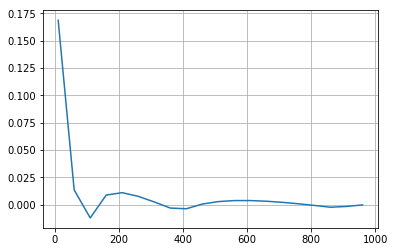

In [120]:
plt.grid()
plt.plot(steps, prices-ref)

The above plot should show you convergence of the error to zero. That is what you should aim for using your own model!

If you do not get the right result, try to reproduce the two step tree from the script or try running the pricer with the rate set to zero. 

## Fixing the Number of Steps

Your model takes all the input parameters and the number of steps to run, but four your model to participate in our
game, you need to fix the number of steps. Your model needs to have the following signature:

    def pricefunction(spot, strike, tau, rate, vola)

We can fix the number of steps and return a function with this signature using the 'partial' function:

    shark10 = partial(shark, 10)
    shark100 = partial(shark, 100)

In [88]:
from tradgame import *
shark30 = partial(shark, 30)
shark100 = partial(shark, 100)

## Run Unit Tests

We have given you a few unit tests that you should try to make sure that your model is returning a correct price.
These tests can give you a hint on what is going wrong.

'RunTests' takes a pricing function and runs several unit tests. If any of these fails you will see a message and the function will return false. If all tests pass it will return true.

Note that you should still compare your model to the analytical solution of Black Scholes as the unit tests only test some limiting cases.

In [83]:
from UnitTest import RunTests
RunTests(bs.bscall) # this obviously passes, try it with RunTests(shark30) to see it fail

True

## How Many Steps Do I Need?

Once you have convinced yourself that your model returns the correct price, it is time to tune it for maximal performance: you want to get your prices good enough to stay mid-market but fast enough to react to spot update.

You can run our game locally with your model and try out how many steps are necessary. Our game takes function with the following signature (input parameters)

    def pricefunction(spot, strike, tau, rate, vola)
    
We can fix the number of steps and return a function with this signature using the 'partial' function:

    shark10 = partial(shark, 10)
    shark100 = partial(shark, 100)

Now we can run these models against each other (just compare 2-3 models to limit the load).

In [84]:
gameParameters = {"seed" : 932748239, "quotewidth" : 0.3, "delay" : 0.1, "steps" : 200}
game = TradingGame(gameParameters)
game.run([shark30, shark100])
game.ranking()

Fini. Recorded 200 events.


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Crossing,Delays,MidMarketness,Name,PnL
1,200,NaN,0.0,shark:30,-100000
2,200,NaN,0.0,shark:100,-100000


The above table, produced by

    game.ranking()

and contains the following information:
* Crossing: how many times the model returned a price which was outside the quotes, i.e. smaller than the bid or larger than the ask. This is really bad as you can be arbitraged very easily.
* MidMarketness: if you are within the bid/ask spread, how close were you on average to the mid-market value
* Delays: how long did it take you on average to respond to a spot update

You can plot how the market moved and your models prices using

    EventPlot(game).plot()
    


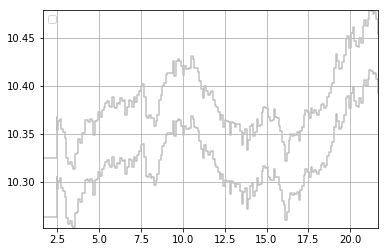

In [87]:
EventPlot(game).plot()

If you want to dig really deep, you can look at all the events the market received by using

    game.getEvents()
    
This shows you the each spot/quote update and when your pricer reacted to it and with which price.

## Timing Your Model

It is not only the number of steps which determines the time that it takes for your model to calculate a price. It is also the way you programmed it. Maybe you want to try out different strategies, but how can you tell which one is faster? Fortunately ipython has a tool for this:

In [86]:
%time shark(spot, OPTION["strike"], OPTION["tau"], OPTION["rate"], OPTION["vola"], 100)

Wall time: 11 ms


[7.678976092678079]

## How Do I Submit My Pricer

Once you have a working pricer, think you have the best balance between accuracy and performance and the time is up, you have to submit the pricer so that it can part in the competition.

For that I would ask you to copy your pricer to a file called **team_xx.py** with xx being your team number.
This file should look something like this:

    def team_xx_pricer(spot, strike, tau, rate, vola, steps):
         ...
         
    pricer = partial(team_xx_pricer, <best_number_of_steps>)
    
    